## Class Imbalance

In [1]:
from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.utils import resample
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,confusion_matrix, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import xgboost as xgb



In [2]:
def plot_decision_boundary(clf, X, y, ax):
    plot_step = 0.02
    n_classes = 2
    plot_colors = "rgb"

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap="BuGn")

    ax.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=40, cmap='winter',edgecolor='black');


In [3]:
def generate_classification_data(num_samples_majority,num_samples_minority, num_features, separation=2.0, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    # Generate the feature values for the first class
    class1_features = np.random.randn(num_samples_majority, num_features) + separation

    # Generate the feature values for the second class
    class2_features = np.random.randn(num_samples_minority, num_features)

    # Concatenate the feature values for both classes
    features = np.concatenate((class1_features, class2_features), axis=0)

    # Generate the labels for the two classes
    class1_labels = np.zeros(num_samples_majority)
    class2_labels = np.ones(num_samples_minority)
    labels = np.concatenate((class1_labels, class2_labels))

    # Shuffle the features and labels in the same order
    indices = np.random.permutation(num_samples_majority+num_samples_minority)
    features = features[indices]
    labels = labels[indices]

    return features, labels


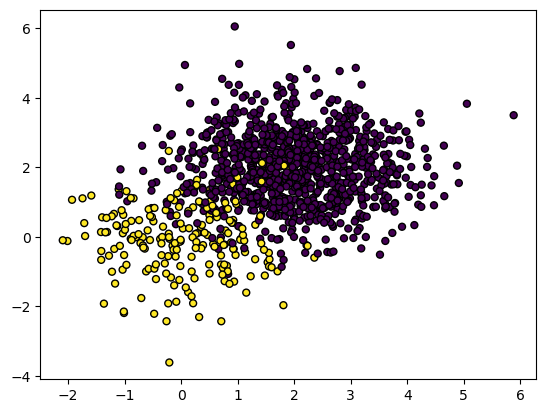

In [21]:
X, y = generate_classification_data(num_samples_majority=1000, num_samples_minority=200,num_features=2)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")

In [22]:
Counter(y)

Counter({0.0: 1000, 1.0: 200})

Instead of the imblearn package, the following function can also be used

In [1]:
import numpy as np
from sklearn.utils import resample

def balance_dataset(X, y, ratio=1):
    """
    Balance a dataset using random under sampling.
    minority_class_count*ratio will be sampled from majority class
    
    """
    # Identify unique class labels and their counts
    unique_classes, class_counts = np.unique(y, return_counts=True)
    
    # Find the majority class
    majority_class = unique_classes[np.argmax(class_counts)]
    
    # Find the count of the minority class
    minority_class_count = np.min(class_counts)
    
    # Resample the majority class to match the count of the minority class
    X_majority = X[y == majority_class]
    y_majority = y[y == majority_class]
    
    X_resampled, y_resampled = resample(X_majority, y_majority,
                                        n_samples=minority_class_count*ratio,
                                        replace=False)
    
    # Combine the resampled majority class with the original minority class instances
    X_balanced = pd.concat([X[y != majority_class], pd.DataFrame(X_resampled, columns=X.columns)], axis=0)
    y_balanced = np.concatenate((y[y != majority_class], y_resampled))
   
    return X_balanced, y_balanced

Now, let us first build classifiers on the imbalanced dataset.

In [24]:

classifiers = [LogisticRegression(), SVC(), DecisionTreeClassifier(), GradientBoostingClassifier(), RandomForestClassifier(), xgb.XGBClassifier()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
for clf in classifiers:
    print(clf.__class__.__name__)
    
    clf.fit(X_train, y_train);

    y_pred = clf.predict(X_test)  

    print(classification_report(y_test,y_pred))


LogisticRegression
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       101
         1.0       0.88      0.79      0.83        19

    accuracy                           0.95       120
   macro avg       0.92      0.88      0.90       120
weighted avg       0.95      0.95      0.95       120

SVC
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       101
         1.0       0.88      0.74      0.80        19

    accuracy                           0.94       120
   macro avg       0.91      0.86      0.88       120
weighted avg       0.94      0.94      0.94       120

DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       101
         1.0       0.78      0.74      0.76        19

    accuracy                           0.93       120
   macro avg       0.86      0.85      0.86       120
weighted avg       0.92     

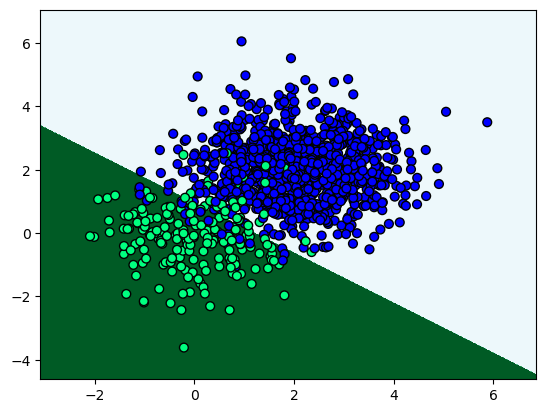

In [25]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
ax = plt.gca()
plot_decision_boundary(clf, X, y ,ax)

Now, let us under sample the majority class, so that, the number of instances in each class become equivalent

In [26]:
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0.0: 181, 1.0: 181})

In [27]:

for clf in classifiers:
    print(clf.__class__.__name__)

    clf.fit(X_resampled, y_resampled);

    y_pred = clf.predict(X_test)  

    print(classification_report(y_test,y_pred))



LogisticRegression
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       101
         1.0       0.74      0.89      0.81        19

    accuracy                           0.93       120
   macro avg       0.86      0.92      0.88       120
weighted avg       0.94      0.93      0.94       120

SVC
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       101
         1.0       0.77      0.89      0.83        19

    accuracy                           0.94       120
   macro avg       0.88      0.92      0.90       120
weighted avg       0.95      0.94      0.94       120

DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       101
         1.0       0.65      0.89      0.76        19

    accuracy                           0.91       120
   macro avg       0.82      0.90      0.85       120
weighted avg       0.93     

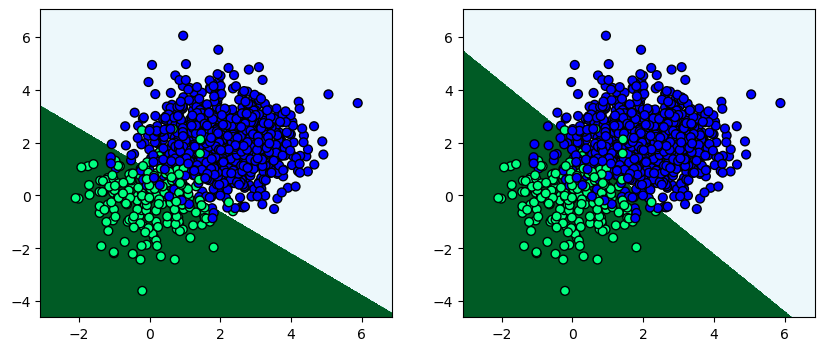

In [28]:
f, axarr = plt.subplots(1,2)
f.set_size_inches(10,4)
clf = LogisticRegression()
ax = plt.gca()
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y, ax=axarr[0])
clf.fit(X_resampled, y_resampled)
plot_decision_boundary(clf, X, y, ax=axarr[1])

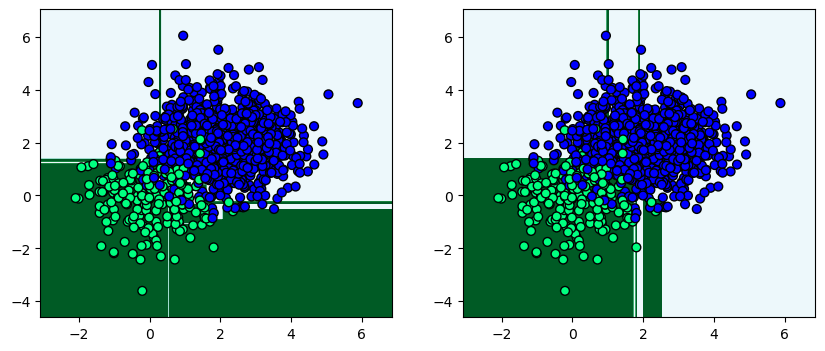

In [29]:
f, axarr = plt.subplots(1,2)
f.set_size_inches(10,4)
clf = DecisionTreeClassifier()
ax = plt.gca()
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y, ax=axarr[0])
clf.fit(X_resampled, y_resampled)
plot_decision_boundary(clf, X, y, ax=axarr[1])

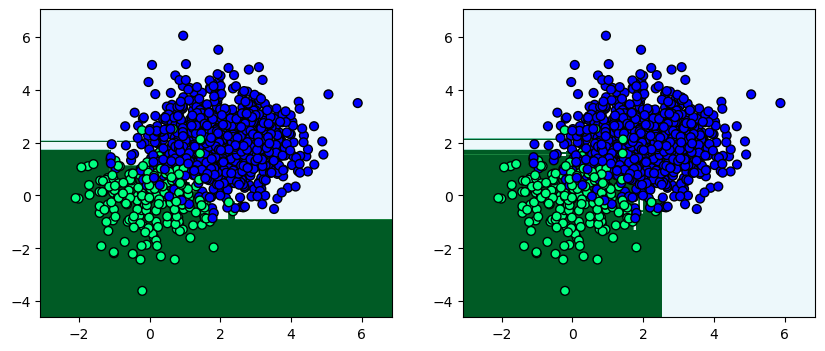

In [30]:
f, axarr = plt.subplots(1,2)
f.set_size_inches(10,4)
clf = GradientBoostingClassifier()
ax = plt.gca()
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y, ax=axarr[0])
clf.fit(X_resampled, y_resampled)
plot_decision_boundary(clf, X, y, ax=axarr[1])

In general, balancing the class distribution shifts the decision boundary towards the majority class, hence, decreases precision but increases recall.

# Bank Marketing Dataset

In [31]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
# print first 5 examples
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [32]:
bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [34]:
bank_majority = bank[bank.y=="no"]
bank_minority = bank[bank.y=="yes"]
 
# downsample
bank_majority_downsampled = resample(bank_majority, 
                                 replace=False,    
                                 n_samples=5289) 
 
bank_balanced = pd.concat([bank_minority, bank_majority_downsampled])
bank_balanced.y.value_counts()

yes    5289
no     5289
Name: y, dtype: int64

Below experiment is done with the unbalanced dataset

In [45]:
X = bank.loc[:,'age':'poutcome']
y = bank.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);

y_pred1 = clf1.predict(X_test)  
y_pred2 = clf2.predict(X_test)  

print(classification_report(y_test,y_pred1))
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3999
           1       0.48      0.50      0.49       523

    accuracy                           0.88      4522
   macro avg       0.71      0.71      0.71      4522
weighted avg       0.88      0.88      0.88      4522

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3999
           1       0.62      0.41      0.50       523

    accuracy                           0.90      4522
   macro avg       0.78      0.69      0.72      4522
weighted avg       0.89      0.90      0.89      4522



The experiment below is done with the balanced dataset. This result might be misleading if the true distribution of the class is imbalanced. 

In [37]:
X = bank_balanced.loc[:,'age':'poutcome']
y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
rus = RandomUnderSampler()
X, y = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);

y_pred1 = clf1.predict(X_test)  
y_pred2 = clf2.predict(X_test)  

print(classification_report(y_test,y_pred1))
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       529
           1       0.77      0.78      0.78       529

    accuracy                           0.78      1058
   macro avg       0.78      0.78      0.78      1058
weighted avg       0.78      0.78      0.78      1058

              precision    recall  f1-score   support

           0       0.88      0.81      0.85       529
           1       0.83      0.89      0.86       529

    accuracy                           0.85      1058
   macro avg       0.86      0.85      0.85      1058
weighted avg       0.86      0.85      0.85      1058



A better approach is to do the balancing after train/test split

In [56]:
X = bank.loc[:,'age':'poutcome']
y = bank.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

rus = RandomUnderSampler(sampling_strategy=1)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);

y_pred1 = clf1.predict(X_test)  
y_pred2 = clf2.predict(X_test)  

print(classification_report(y_test,y_pred1))
print(classification_report(y_test,y_pred2))


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3976
           1       0.48      0.50      0.49       546

    accuracy                           0.88      4522
   macro avg       0.71      0.71      0.71      4522
weighted avg       0.88      0.88      0.88      4522

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      3976
           1       0.67      0.39      0.49       546

    accuracy                           0.90      4522
   macro avg       0.80      0.68      0.72      4522
weighted avg       0.89      0.90      0.89      4522



We can conclude that, balancing might help, but as with any ML model development, the evaluation framework should be carefully setup.

### References

[To SMOTE, or not to SMOTE?](https://arxiv.org/abs/2201.08528)
Claims that balancing only works when weak learners are used. Balancing does not improve the performance of strong learners (like XGBoost, Random Forests, etc.)